In [ ]:
#Import packages and directories
#!pip install lightgbm
#!pip install seaborn

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score)
from sklearn.ensemble import HistGradientBoostingRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

#Set directory

os.chdir('') #Set the system directory

#Set seed


#Import dataset

data = pd.read_csv("DE_utc.csv")
#print(data.head())


c:\Users\Raunak\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
c:\Users\Raunak\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
c:\Users\Raunak\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#Generate a cleaned dataset

data_clean = data.drop(data.columns[[3,5,7,9,10,11,13,15,16,20,22,23,24]],axis = 1)

#Generate separate columns for date and time

data_clean['DateTime'] = pd.to_datetime(data_clean['DateTime'])
data_clean.loc[:,'Year'] = data_clean['DateTime'].dt.year
data_clean.loc[:,'Month'] = data_clean['DateTime'].dt.month
data_clean.loc[:,'Day'] = data_clean['DateTime'].dt.day
data_clean.loc[:,'Time']  = data_clean['DateTime'].dt.time

#print(data_clean.isnull().sum()) #Check for null values

#Drop null values for the Price variable and forward fill commodities like Oil, Gas, Coal
#  
data_clean = data_clean.dropna(subset = ['Price'])
data_clean = data_clean.fillna(method='ffill')

#Generate a dummy variable for fixed public holidays

data_clean['Holiday'] = data_clean.apply(lambda row: 1 if (row['Month']==12 and row['Day'] in [24,25])
                                         else 1 if (row['Month'] == 1 and row['Day'] == 1)
                                               else 0, axis = 1) 

#Generate a price lag variable 

data_clean['price_lag_week'] = data_clean['Price'].shift(24*7) #for d-7, that is, the previous week
data_clean['price_lag_one'] = data_clean['Price'].shift(24) #For one day before

#Account for outliers using IQR

#Calculate Q1 and Q3
Q1 = data_clean['Price'].quantile(0.25)
Q3 = data_clean['Price'].quantile(0.75)

#Calculate IQR
IQR = Q3 - Q1

#Calculate lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR 

# Create an indicator for outliers based on IQR bounds
data_clean['is_outlier'] = ((data_clean['Price'] < lower_bound) | (data_clean['Price'] > upper_bound)).astype(int)

# Create a rolling price volatility variable to capture market shocks
data_clean['rolling_std_7'] = data_clean['Price'].rolling(window=7).std()  # 7-day volatility





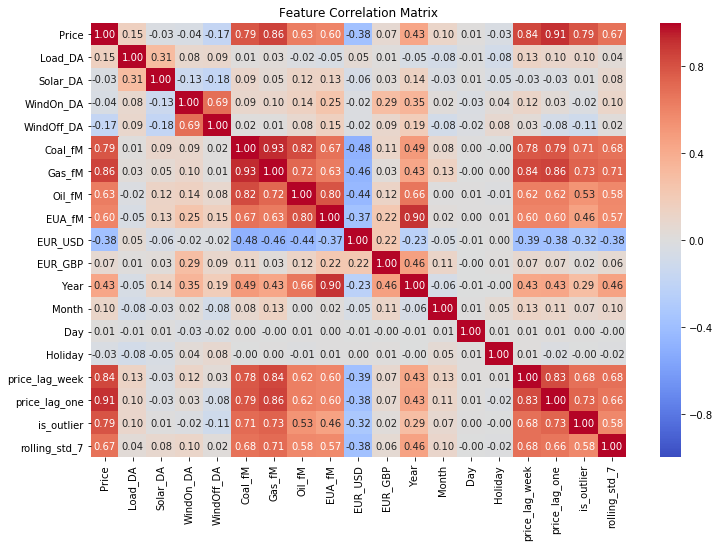

In [3]:
# Correlation analysis
correlation_matrix = data_clean.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will 

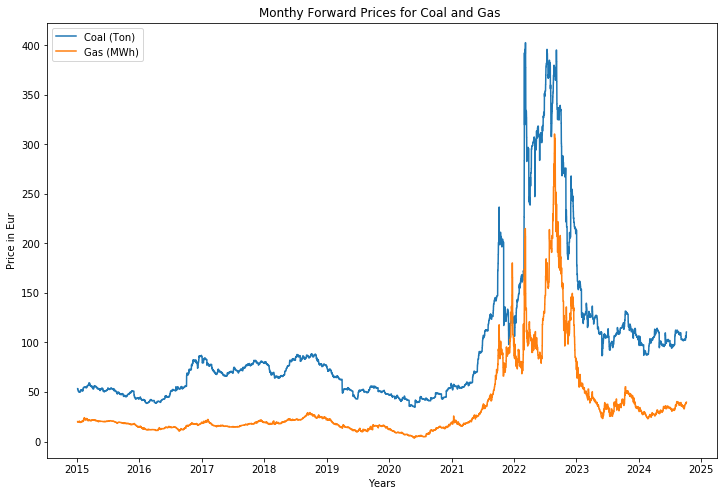

In [4]:
# Summary Review

#print(data_clean.describe())

#Plots of variables of interest
plt.figure(figsize=(12, 8))
plt.plot(data_clean['DateTime'],data_clean['Coal_fM'],label = "Coal (Ton)")
plt.plot(data_clean['DateTime'],data_clean['Gas_fM'], label = "Gas (MWh)")
plt.xlabel('Years')
plt.ylabel('Price in Eur')
plt.title('Monthy Forward Prices for Coal and Gas ')
plt.legend(loc='upper left')
plt.show()

c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will 

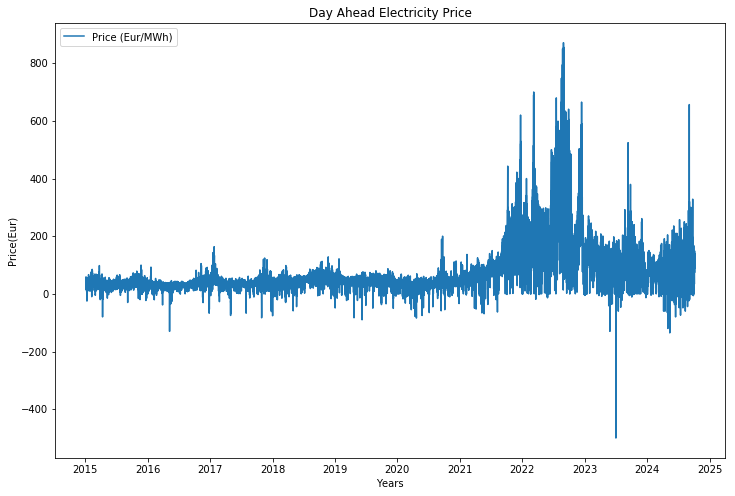

In [5]:
#Plots of variables of interest
plt.figure(figsize=(12, 8))
plt.plot(data_clean['DateTime'],data_clean['Price'], label = 'Price (Eur/MWh)')
plt.xlabel('Years')
plt.ylabel('Price(Eur)')
plt.title('Day Ahead Electricity Price')
plt.legend(loc='upper left')
plt.show()

c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will 

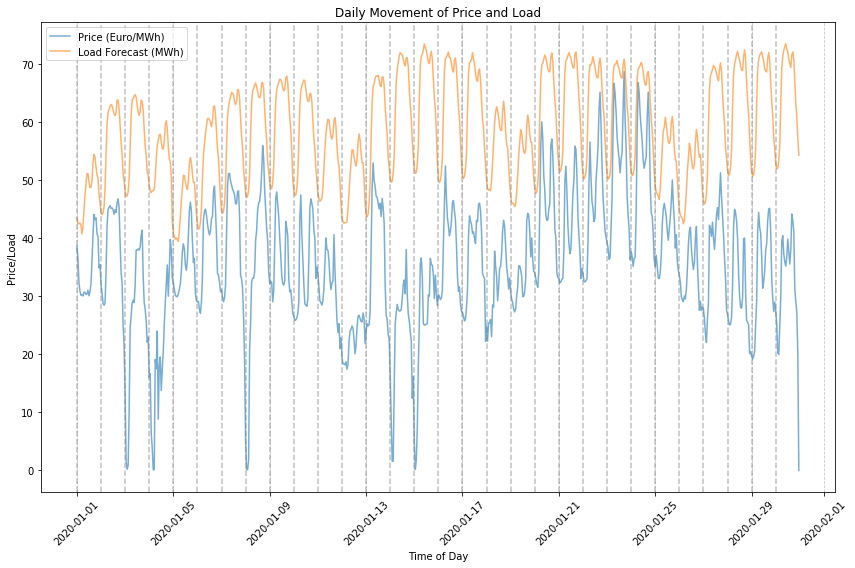

In [6]:
#Function to plot daily volatility with time shown within the month, splitting days with vertical lines

def dailyprice(year,month,day_start,day_end):

    plot1 = data_clean[(data_clean['Year']==year) & (data_clean['Month']==month)]  
    plot1 = plot1[(plot1['Day']>= day_start) & (plot1['Day']<=day_end)]
    plt.figure(figsize=(12, 8))
    plt.plot(plot1['DateTime'], plot1['Price'], label='Price (Euro/MWh)', alpha=0.6)
    plt.plot(plot1['DateTime'], plot1['Load_DA'], label='Load Forecast (MWh)', alpha=0.6)

    # Add vertical lines for each day
    unique_days = plot1['DateTime'].dt.date.unique()
    for day in unique_days:
        plt.axvline(pd.Timestamp(day), color='grey', linestyle='--', alpha=0.5)

    # Customize plot
    #plt.ylim(-50,100)
    plt.xlabel('Time of Day')
    plt.ylabel('Price/Load')
    plt.title('Daily Movement of Price and Load')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

dailyprice(2020,1,1,30)

c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\Raunak\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will 

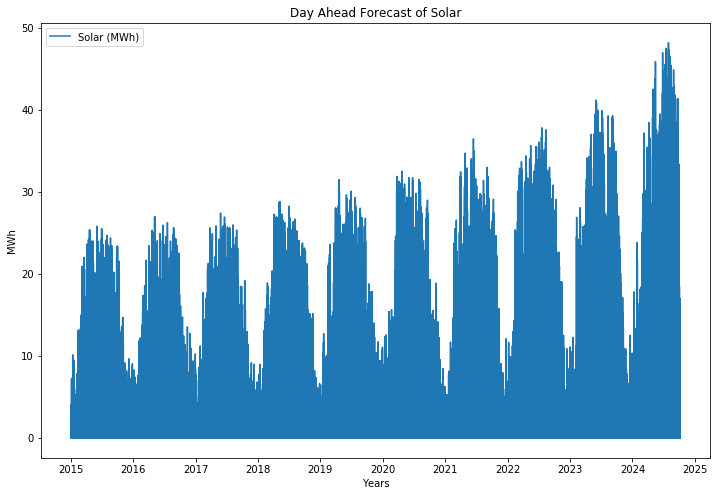

In [7]:
#Plots of variables of interest
plt.figure(figsize=(12, 8))
plt.plot(data_clean['DateTime'],data_clean['Solar_DA'], label = "Solar (MWh)")
plt.xlabel('Years')
plt.ylabel('MWh')
plt.title('Day Ahead Forecast of Solar')
plt.legend(loc='upper left')
plt.show()

In [8]:
#Quantile Regression through LightGBM 

# Function for calculating Pinball Loss
def pinball_loss(y_true, y_pred, tau):
    residual = y_true - y_pred
    return np.mean(np.maximum(tau * residual, (tau - 1) * residual))

#Split dataset into Dependent variable and Predictor variable
x = data_clean.drop(columns=['DateTime','Price','Year','Day','Time'])
y = data_clean['Price']

# Set quantiles for which you want to perform regression
quantiles = np.concatenate(([0.01],np.arange(0.1,1,0.1),[0.99]))


# Create an empty dictionary to store the predictions
y_pred_train = {f'Quantile {int(tau*100)}%':[] for tau in quantiles} #For training data
y_pred = {f'Quantile {int(tau*100)}%':[] for tau in quantiles} #For testing data


# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 splits

# Store results for each fold and quantile
results_train = {'Quantile': [], 'Fold': [], 'Pinball Loss': [], 'MAE': [],'RMSE':[],'R-Squared': []}
results_test = {'Quantile': [], 'Fold': [], 'Pinball Loss': [], 'MAE': [],'RMSE':[],'R-Squared': []}

# Train and test the model using TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tscv.split(x)):
    # Split data into train and test
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a model for each quantile
    for tau in quantiles:
        model = lgb.LGBMRegressor(objective='quantile', alpha=tau, n_estimators=200, num_leaves=31, learning_rate=0.1,random_state = 42)
                
        # Fit the model
        model.fit(x_train, y_train)

        #Make predictions on training data
        y_train_pred = model.predict(x_train)
        y_pred_train[f'Quantile {int(tau*100)}%'].extend(y_train_pred)

        # Make predictions on testing data
        y_pred_model = model.predict(x_test) 
        y_pred[f'Quantile {int(tau*100)}%'].extend(y_pred_model)

        #Calculate metrics

        #For training data
        pinball_train = pinball_loss(y_train, y_train_pred, tau)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
        rsquared_train = r2_score(y_train,y_train_pred)

        # Store the results
        results_train['Quantile'].append(tau)
        results_train['Fold'].append(fold + 1)
        results_train['Pinball Loss'].append(pinball_train)
        results_train['MAE'].append(mae_train)
        results_train['RMSE'].append(rmse_train)
        results_train['R-Squared'].append(rsquared_train)
        
        #For testing data
        pinball_test = pinball_loss(y_test, y_pred_model, tau)
        mae_test = mean_absolute_error(y_test, y_pred_model)
        rmse_test = np.sqrt(mean_squared_error(y_test,y_pred_model)) 
        rsquared_test = r2_score(y_test,y_pred_model)

        # Store the results
        results_test['Quantile'].append(tau)
        results_test['Fold'].append(fold + 1)
        results_test['Pinball Loss'].append(pinball_test)
        results_test['MAE'].append(mae_test)
        results_test['RMSE'].append(rmse_test)
        results_test['R-Squared'].append(rsquared_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3308
[LightGBM] [Info] Number of data points in the train set: 14248, number of used features: 15
[LightGBM] [Info] Start training from score -0.085300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3308
[LightGBM] [Info] Number of data points in the train set: 14248, number of used features: 15
[LightGBM] [Info] Start training from score 16.170000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3308
[LightGBM] [Info] Number of data points in the train s

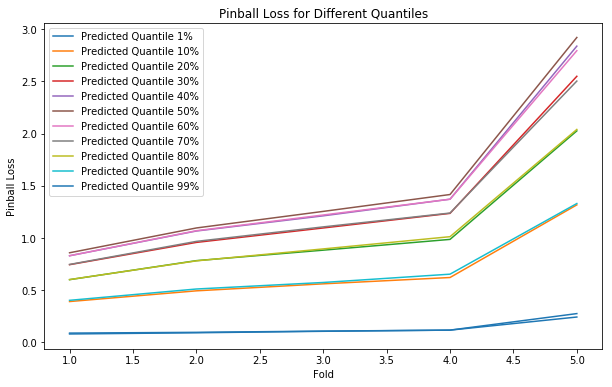

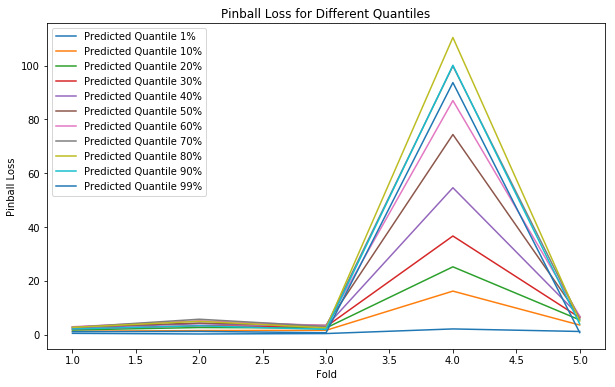

In [13]:
# Convert the results into a DataFrame
results_train_df = pd.DataFrame(results_train)
results_test_df = pd.DataFrame(results_test)
 
# Plot the Pinball Loss metrics for training data
plt.figure(figsize=(10, 6))
for tau in quantiles:
    quantile_data_train = results_train_df[results_train_df['Quantile'] == tau]
    plt.plot(quantile_data_train['Fold'], quantile_data_train['Pinball Loss'], label=f'Predicted Quantile {int(tau*100)}%')
plt.xlabel('Fold')
plt.ylabel('Pinball Loss')
plt.title('Pinball Loss for Different Quantiles')
plt.legend()
plt.show()

#Plot the Pinball Loss metrics for testing data
plt.figure(figsize=(10, 6))
for tau in quantiles:
    quantile_data = results_test_df[results_test_df['Quantile'] == tau]
    plt.plot(quantile_data['Fold'], quantile_data['Pinball Loss'], label=f'Predicted Quantile {int(tau*100)}%')    
plt.xlabel('Fold')
plt.ylabel('Pinball Loss')
plt.title('Pinball Loss for Different Quantiles')
plt.legend()
plt.show()


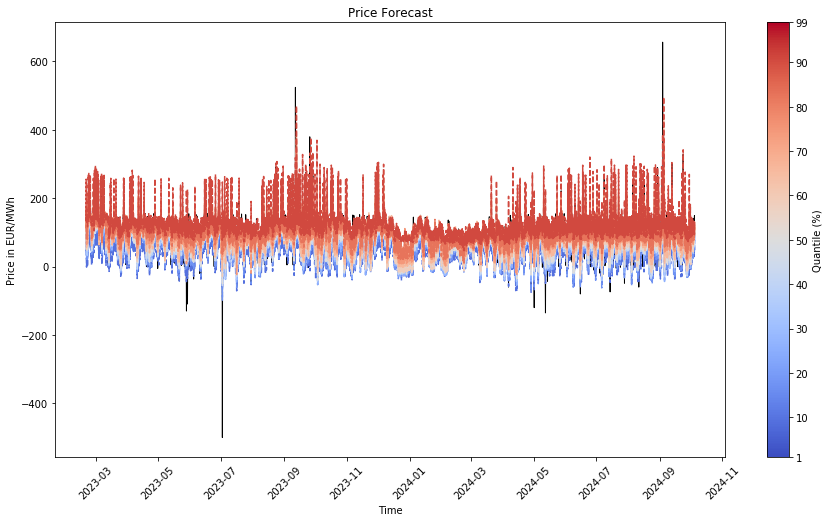

In [10]:
# Graph for prediction interval based on last fold

last_train_index,last_test_index = list(tscv.split(x,y))[-1]

# Extract the values for last fold's test set
pred_result = pd.DataFrame(y_pred)
pred_result = pred_result.iloc[-len(last_test_index):,]

#Extract testing dataset for the last fold
y_test_last = y.iloc[last_test_index]

# Extract the Year column for the last fold's test set
dates_test = data_clean.iloc[last_test_index]['DateTime']  

# Plot the results
plt.figure(figsize=(15,8))

# Plot actual values
plt.plot(dates_test.values,y_test_last.values, label='Actual Price', color='black', linewidth=1)

# Plot predicted quantiles
colors = sns.color_palette('coolwarm',len(quantiles))

for i,tau in enumerate(quantiles):
    plt.plot(dates_test.values,pred_result[f'Quantile {int(tau*100)}%'], label=f'Predicted Quantile {int(tau*100)}%',color = colors[i],linestyle='--')
    
# Add color bar to show quantiles, using a continuous scalar mappable
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=1, vmax=99))
sm.set_array([])
cbar = plt.colorbar(sm, ticks = np.concatenate(([1],np.arange(10,100,10),[99])))
cbar.set_label('Quantile (%)')
cbar.ax.set_yticklabels([f'{int(tick)}' for tick in np.concatenate(([1],np.arange(10,100,10),[99]))])

# Set the x-axis limit up to January 2024
#plt.xlim([pd.to_datetime('2023-11'), pd.to_datetime('2024-01')])
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price in EUR/MWh')
plt.title('Price Forecast')
plt.xticks(rotation=45)
#plt.legend(loc='upper left')
plt.grid(False)
plt.show()


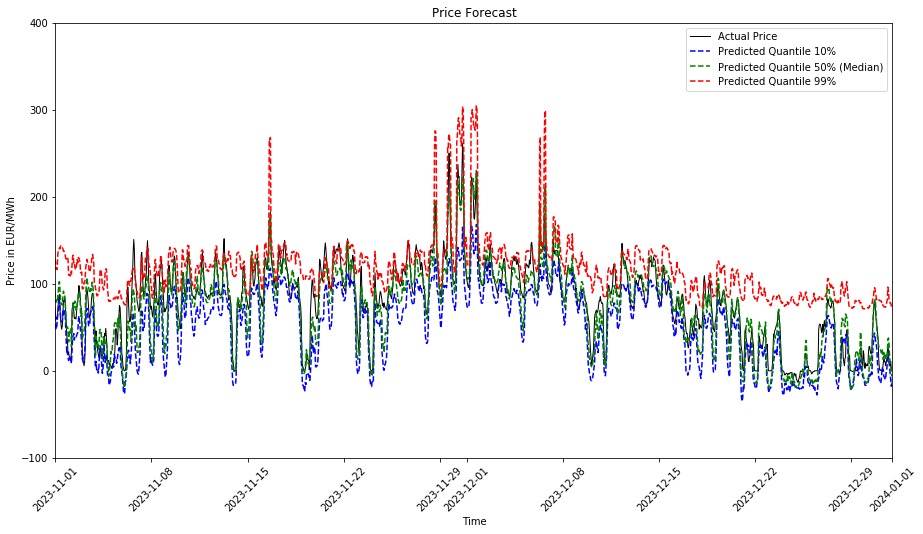

In [11]:
# Graph for prediction interval based on last fold for a few quantiles

# Plot the results
plt.figure(figsize=(15,8))

# Plot actual values
plt.plot(dates_test.values,y_test_last.values, label='Actual Price', color='black', linewidth=1)

for tau in [0.1,0.5,0.99]:
    if tau == 0.5:
       plt.plot(dates_test.values,pred_result['Quantile 50%'], label=f'Predicted Quantile 50% (Median)',color = 'green',linestyle='--')
    elif tau == 0.1 :
        plt.plot(dates_test.values,pred_result['Quantile 10%'], label='Predicted Quantile 10%',color = 'blue',linestyle='--')
    elif tau == 0.99:  
        #plt.plot(dates_test.values,pred_result['Quantile 70%'], label='Predicted Quantile 75%', color='yellow', linestyle='--')
        plt.plot(dates_test.values,pred_result['Quantile 99%'], label='Predicted Quantile 99%', color='red', linestyle='--')


# Set the x-axis limit up to January 2024
plt.xlim([pd.to_datetime('2023-11'), pd.to_datetime('2024-01')])
#set y-axis limit
plt.ylim(-100,400)
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price in EUR/MWh')
plt.title('Price Forecast')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(False)
plt.show()
